### https://www.kaggle.com/arootda/titanic-eda-modeling-for-beginners-top3

In [ ]:
!pip install xgboost

In [3]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 90)
import matplotlib.pyplot as plt
import seaborn as sns
PALETTE = ['#dd4124','#009473', '#b4b4b4', '#336b87']
BACKCOLOR = '#f6f5f5'
sns.set_palette(PALETTE)

from scipy.stats import norm, probplot, skew
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold, train_test_split, RandomizedSearchCV
from sklearn.neighbors import  KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix

from IPython.core.display import HTML

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [4]:
# Import training and test data.
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# When exploring a dataset, it is recommended to use the entire data.
all_data = pd.concat((train, test)).reset_index(drop=True)

In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [ ]:
multi_table([pd.DataFrame(all_data[i].value_counts()) for i in all_data.columns])

In [23]:
numerical_vars = ['Age', 'SibSp', 'Parch', 'Fare']
ordinal_vars = ['Pclass']
nominal_vars = ['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [20]:
all_data['Embarked'].isnull().sum()

0

In [19]:
all_data.dropna(subset=['Embarked'], inplace=True)

In [ ]:
all_data.Cabin

In [22]:
# missing values
all_data['Age'] = all_data.Age.fillna(train.Age.median())
all_data['Fare'] = all_data.Fare.fillna(train.Fare.median())
all_data.dropna(subset=['Embarked'], inplace=True)
cabins = all_data.Cabin
all_data.drop(['Cabin'], axis=1, inplace=True)

In [60]:
# se for vazio, coloca 0, senao conta quantas cabines a pessoa comprou (separado por espaço)
all_data['CabinCnt'] = cabins.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# Pega a 1a letra do nome da cabine. Se for vazio, pega a 1a letra do nan (vazio)
all_data['CabinClass'] = cabins.apply(lambda x: str(x)[0])
# transforma a passagens numericas em 1, e as texto em 0
all_data['IsNumericTicket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
# transforma o nome do ticket em um padrao
all_data['TicketType'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else 0)
# Separa o titulo do nome da pessoa
all_data['Title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
# Soma pais e filhos de cada um
all_data['Family'] = all_data.SibSp + all_data.Parch

In [ ]:
all_data['CabinCnt'].value_counts()

In [33]:
all_data['CabinCnt'].shape

(1307,)

In [ ]:
all_data['CabinClass'].value_counts()

In [51]:
cabins[0]

nan

In [ ]:
all_data.Ticket.value_counts()

In [ ]:
all_data.TicketType.value_counts()

In [64]:
all_data['Family'].value_counts().sort_index()

0     788
1     235
2     159
3      43
4      22
5      25
6      16
7       8
10     11
Name: Family, dtype: int64

In [71]:
# feature transform
numeric_vars = ['Age', 'SibSp', 'Parch', 'Fare', 'CabinCnt', 'Family']
ordinal_vars = ['Pclass']
nominal_vars = ['Name', 'Sex', 'Ticket', 'Embarked', 'CabinClass', 'IsNumericTicket', 'TicketType', 'Title']
# Transforma todas features nominais em string
all_data[nominal_vars] = all_data[nominal_vars].astype('str')

# Converte todas festures numericas em log1p
for feature in numeric_vars:
    all_data[feature] = np.log1p(all_data[feature])

# escolhe o modelo que normaliza os valores numericos
scaler = StandardScaler()
# Seleciona todos os numericos, de novo. Nesse caso ele inclui o Pclass
numeric_vars = all_data.columns[(all_data.dtypes != 'object') & (all_data.columns != 'PassengerId') & (all_data.columns != 'Survived') & (all_data.columns != 'IsTrain')]
all_data[numeric_vars] = scaler.fit_transform(all_data[numeric_vars])

In [ ]:
all_data[nominal_vars].info()

In [ ]:
# split data
# Remove algumas colunas
all_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
# Faz a conversao de one-hot coding
data_dummies = pd.get_dummies(all_data)
# Cria o conjunto de treino, retirando as linhas nulas e apagando a coluna de Survived
X_train = data_dummies[data_dummies.Survived.notnull()].drop(['Survived'], axis=1)
# Separa a coluna Survived retirando os vazios
y_train = data_dummies[data_dummies.Survived.notnull()].Survived
# Separa o conjunto de teste, que sao os que estão com o campo vazio no Survived
X_test = data_dummies[data_dummies.Survived.isnull()].drop(['Survived'], axis=1)

In [75]:
X_train.shape, y_train.shape, X_test.shape

((889, 76), (889,), (418, 76))

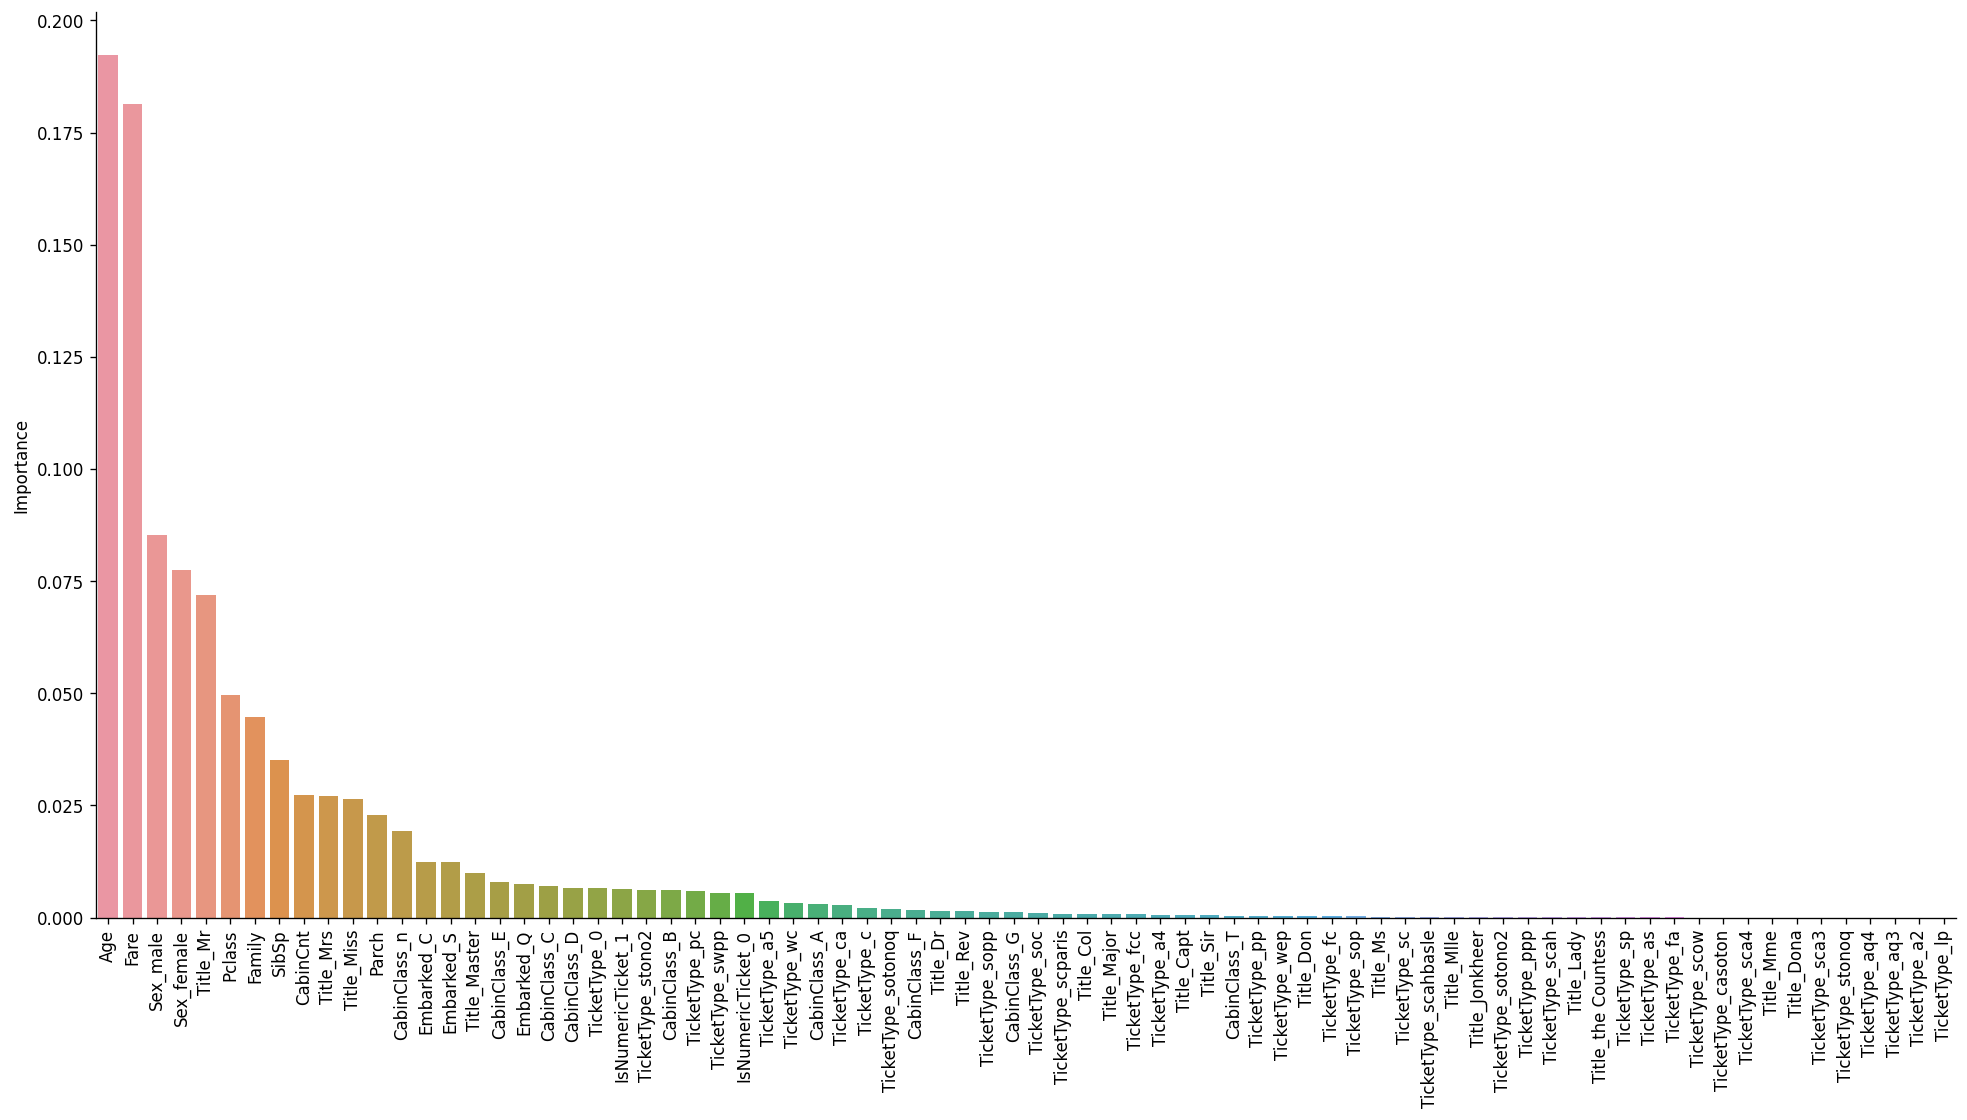

In [76]:
selector = RandomForestClassifier().fit(X_train, y_train)

imps = pd.DataFrame(selector.feature_importances_, X_train.columns, columns=['Importance'])
imps = pd.DataFrame(imps.Importance.sort_values(ascending=False))

plt.subplots(figsize=(20, 10))
g = sns.barplot(x=imps.index, y=imps.Importance)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
plt.show()

In [78]:
all_data.Title = all_data.Title.apply(lambda x: 'Others' if x in list(all_data.Title.value_counts()[all_data.Title.value_counts() < 8].index) else x)
all_data.TicketType = all_data.TicketType.apply(lambda x: 'Others' if x in list(all_data.TicketType.value_counts()[all_data.TicketType.value_counts() < 10].index) else x)

In [79]:
# split data2
data_dummies = pd.get_dummies(all_data)
X_train = data_dummies[data_dummies.Survived.notnull()].drop(['Survived'], axis=1)
X_test = data_dummies[data_dummies.Survived.isnull()].drop(['Survived'], axis=1)

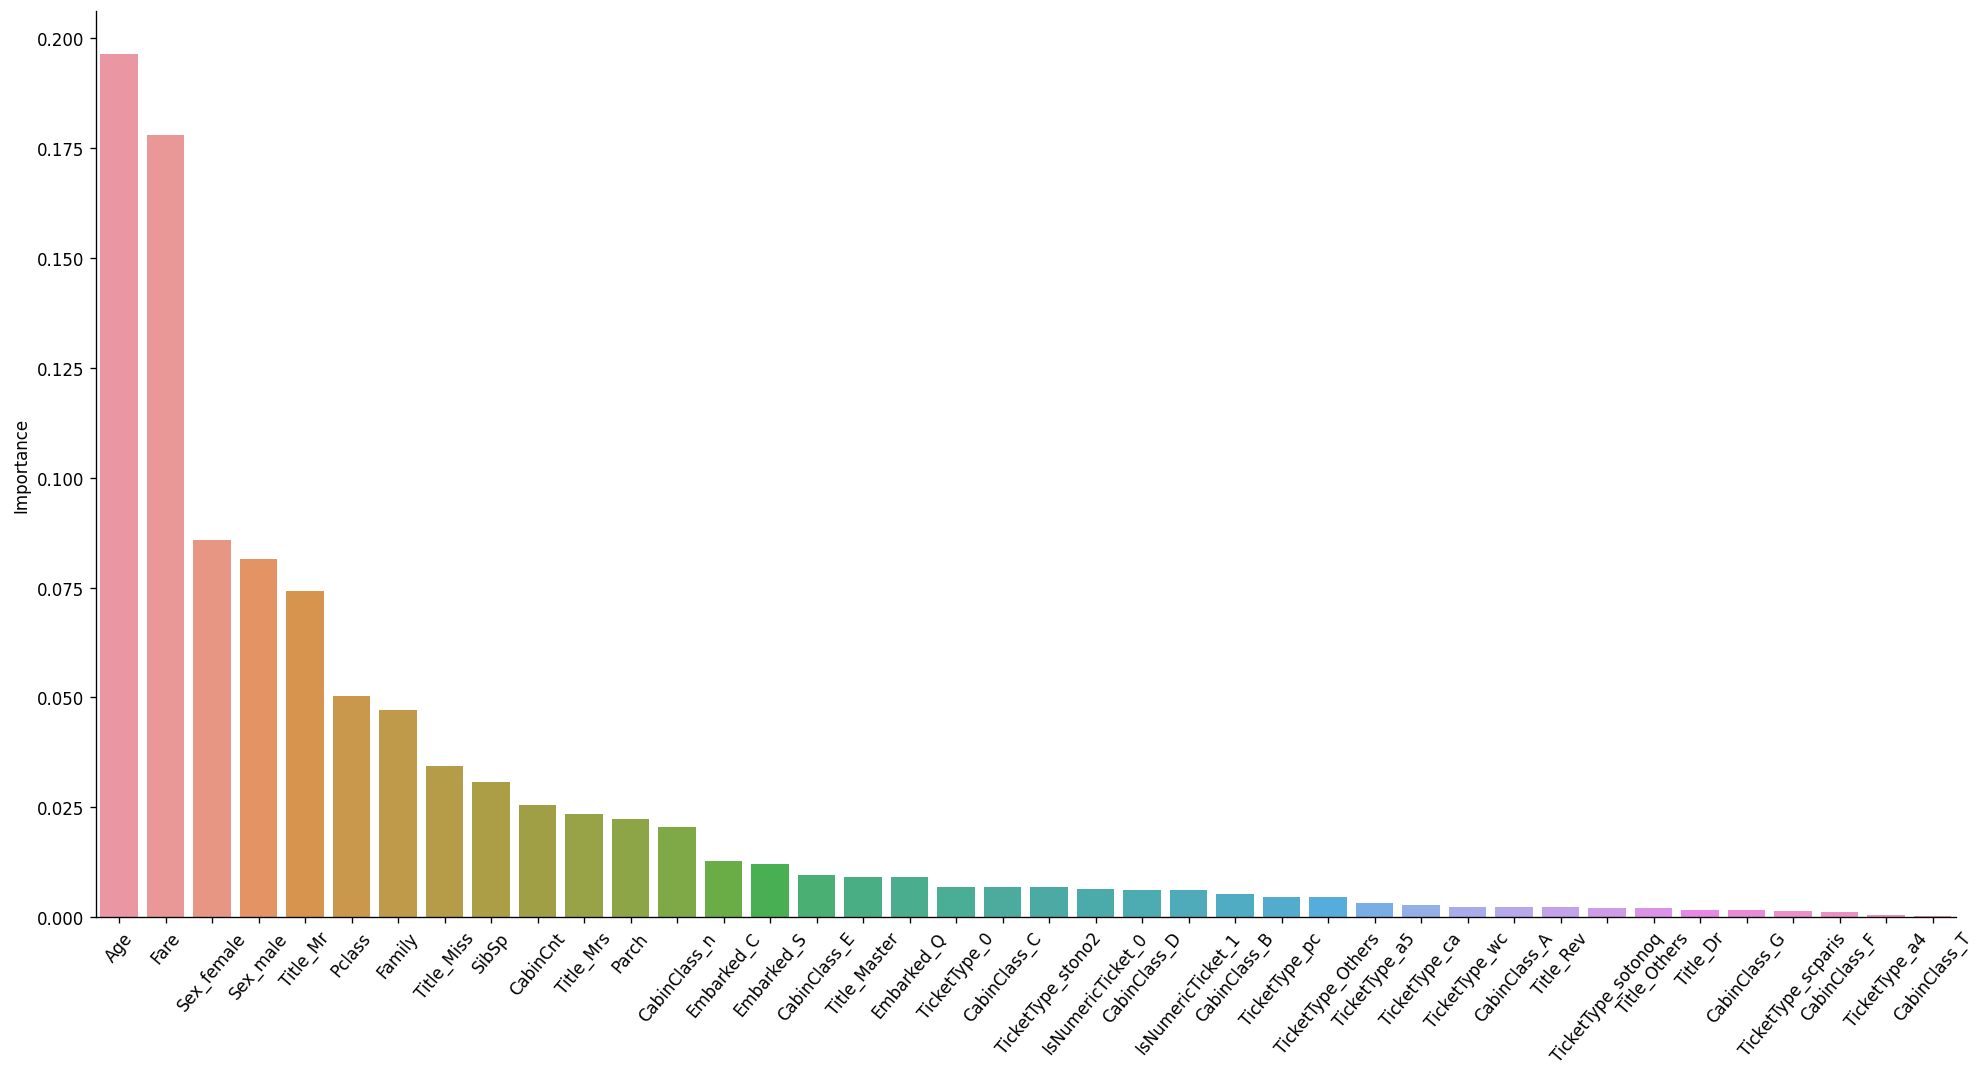

In [80]:
selector = RandomForestClassifier().fit(X_train, y_train)

imps = pd.DataFrame(selector.feature_importances_, X_train.columns, columns=['Importance'])
imps = pd.DataFrame(imps.Importance.sort_values(ascending=False))

plt.subplots(figsize=(20, 10))
g = sns.barplot(x=imps.index, y=imps.Importance)
g.set_xticklabels(g.get_xticklabels(),rotation = 50)
plt.show()

## Modelando

Creating a good model is as important as creating a good variable. A good model refers to a model with the best generalization performance using hyperparameters optimized for a given dataset. To solve this problem, I used Logistic Regression, Knn, Support Vector Machine, Radnom Forest, XGBoost, and Voting Model. Because each model is suitable for binary classification tasks and has different algorithms and characteristics, learning the same dataset can perform differently. In addition, because each model has a different categorization point for key people, it may be better to combine them.

I used Grid Search to find this model's HYPER PARAMTER. Random Forest hyperparameter tuning is too wide and difficult. It is easier to adjust by narrowing the range using Random Search first. XGBoost has many parameters and a wide range, so tuning is more difficult than other models. Therefore, tuning all hyperparameters at once takes a very long time.

XGBoost has many hyperparameters, but there are parameters that have a relatively significant impact. This includes learning_rate and n_estimators. I took advantage of early_stopping to get the best learning_rate, and then tuned the hyperparameters such as max_depth, min_child_weight, gamma, subsample, etc. After tuning the core parameters, the optimal parameters are derived by final tuning the learning_rate and n_estimators again.

In [81]:
# Hyperparameter tuning takes a lot of time. If this variable is False, the tuning process will be omitted and the learning will proceed 
# with the hyperparameters already obtained. If this variable is true, you can proceed with the tuning process directly.
allow_tuning = False

In [82]:
# This function is a function created by myself to eliminate repeated code generated by tuning XGBoost.
# params_grid_xgb: Combines fixed parameters for grid search in xgboost.
# features: Target features to be tuned using this function
# values: Search parameters for each feature
# X,y: Datasets.
# last: If this value is false, change each value of the GridSearchCV object's best_params to a list for immediate use in the next adjustment.
def xgb_gridsearch(params_grid_xgb, features, values, X, y, last=False):
    x_train, x_test = train_test_split(X, test_size=.2, random_state=42)
    y_train_tmp, y_test_tmp = train_test_split(y, test_size=.2, random_state=42)

    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    model_xgb = XGBClassifier(use_label_encoder = False, 
                              objective = 'binary:logistic')
    
    for i in range(len(features)):
        params_grid_xgb[features[i]] = values[i]
    search_xgb = GridSearchCV(model_xgb, params_grid_xgb, verbose = 0,
                              scoring = 'neg_log_loss', cv = cv).fit(x_train, y_train_tmp, early_stopping_rounds = 15, 
                                  eval_set = [[x_test, y_test_tmp]], 
                                  eval_metric = 'logloss', verbose = False)
    for i in range(len(features)):
        print(f"{features[i]}: {search_xgb.best_params_[features[i]]}")
    if not last:
        for k, v in search_xgb.best_params_.items():
            search_xgb.best_params_[k] = [v]
    return search_xgb, search_xgb.best_params_

### KNN

In [83]:
if allow_tuning:
    params_knn = {
        'n_neighbors' : range(1, 10),
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['auto', 'ball_tree','kd_tree'],
        'p' : [1,2]
    }
    model_knn = knn()
    search_knn = GridSearchCV(model_knn, params_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_knn.best_params_)

### Logistic Regression

In [84]:
if allow_tuning:
    params_logistic = {
        'max_iter': [2000],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear']
    }
    model_logistic = LogisticRegression()
    search_logistic = GridSearchCV(model_logistic, params_logistic, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_logistic.best_params_)

### SVC

In [85]:
if allow_tuning:
    params_svc = [{'kernel': ['rbf'], 'gamma': [.01, .1, .5, 1, 2, 5, 10], 'C': [.1, 1, 10, 100, 1000], 'probability': [True]},
                  {'kernel': ['poly'], 'degree' : [2, 3, 4, 5], 'C': [.01, .1, 1, 10, 100, 1000], 'probability': [True]}]
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_svc.best_params_)

In [86]:
if allow_tuning:
    params_svc = {'kernel': ['rbf'], 'gamma': [i/10000 for i in range(90, 110)], 'C': range(50, 80, 10), 'probability': [True]}
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    print(search_svc.best_params_)

### Random Forest

First, use Random Search to narrow the search range, and then proceed with Grid Search. Random search results vary from time to time. Increasing n_iter results in more consistent results.

In [87]:
# if allow_tuning:
#     params_rf = {
#         'n_estimators': range(100, 2000, 200),
#         'criterion':['gini','entropy'],
#         'bootstrap': [True, False],
#         'max_depth': list(range(5, 100, 5)) + [None],
#         'max_features': ['auto','sqrt', 5, 10],
#         'min_samples_leaf': range(2, 11, 2),
#         'min_samples_split': range(2, 11, 2)}
#     model_rf = RandomForestClassifier()
#     search_rf = RandomizedSearchCV(model_rf, params_rf, cv=5,
#                                    scoring='accuracy', n_jobs=-1, verbose=1,
#                                    n_iter=100).fit(X_train, y_train)
#     print(search_rf.best_params_)

In [88]:
if allow_tuning:
    params_rf = {
        'n_estimators': [95, 100, 105],
        'criterion':['entropy'],
        'bootstrap': [True, False],
        'max_depth': [40, 45, 50],
        'max_features': [4, 5, 6],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [9, 10, 11],
        'random_state': [734]}
    model_rf = RandomForestClassifier()
    search_rf = GridSearchCV(model_rf, params_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, y_train)
    search_rf.best_params_['random_state']=242
    search_rf.best_estimator_.random_state=242
    print(search_rf.best_params_)

### XGBoost

In [89]:
if allow_tuning:
    # Initial params.
    params_xgb = {'n_estimators': [1000],
                  'learning_rate': [0.1],
                  'max_depth': [5],
                  'min_child_weight': [1],
                  'gamma': [0],
                  'subsample': [0.8],
                  'colsample_bytree': [0.8],
                  'n_jobs': [-1],
                  'objective': ['binary:logistic'],
                  'use_label_encoder': [False],
                  'eval_metric': ['logloss'],
                  'scale_pos_weight': [1]}
    
    # learning rate tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb, 
                                            ['learning_rate'], 
                                            [[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]],
                                            X_train, y_train)
    # max_depth, min_child_weight tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['max_depth', 'min_child_weight'],
                                            [range(3, 10), range(1, 6)],
                                            X_train, y_train)
    
    # gamma tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['gamma'],
                                            [[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]],
                                            X_train, y_train)
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['subsample', 'colsample_bytree'],
                                            [[i/100.0 for i in range(75,90,5)], [i/100.0 for i in range(75,90,5)]],
                                            X_train, y_train)
    
    # reg_alpha tuning.
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['reg_alpha'], 
                                            [[1e-5, 1e-2, 0.1, 1, 100]], 
                                            X_train, y_train)
    
    # learning rate re tuning.
    params_xgb['n_estimators'] = [5000]
    search_xgb, params_xgb = xgb_gridsearch(params_xgb,
                                            ['learning_rate'],
                                            [[0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2]],
                                            X_train, y_train, last=True)

    x_train, x_test = train_test_split(X_train, test_size=.2, random_state=42)
    y_train_tmp, y_test_tmp = train_test_split(y_train, test_size=.2, random_state=42)
    model_xgb = XGBClassifier(**params_xgb)
    
    # n_estimators tuning.
    model_xgb = model_xgb.fit(x_train, y_train_tmp, eval_set=[(x_test, y_test_tmp)], eval_metric=['logloss'], early_stopping_rounds=15, verbose=0)
    search_xgb.best_estimator_.n_estimators = model_xgb.best_iteration

Create each model based on hyperparameter tuning results. If allow_tuning is False, create a model based on the results tuned in advance.



In [90]:
if allow_tuning:
    model_knn = search_knn.best_estimator_
    model_logistic = search_logistic.best_estimator_
    model_svc = search_svc.best_estimator_
    model_rf = search_rf.best_estimator_
    model_xgb = search_xgb.best_estimator_
else:
    model_knn = knn(algorithm='auto', 
                    n_neighbors=9,
                    p=1, 
                    weights='uniform')
    
    model_logistic = LogisticRegression(C=0.08858667904100823,
                                        max_iter=2000, 
                                        penalty='l2', 
                                        solver='liblinear')
    model_svc = SVC(C=70,
                    gamma=0.0106,
                    kernel='rbf',
                    probability=True)
    
    model_rf = RandomForestClassifier(bootstrap=True,
                                      criterion='entropy',
                                      max_depth=50, max_features=6, 
                                      min_samples_leaf=1, 
                                      min_samples_split=10, 
                                      n_estimators=100,
                                      random_state=734)
    
    model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=0.8,
                              enable_categorical=False, eval_metric='logloss', gamma=0.8,gpu_id=-1, importance_type=None, interaction_constraints='',
                              learning_rate=0.15, max_delta_step=0, max_depth=5,
                              min_child_weight=1, missing=np.nan, monotone_constraints='()',
                              n_estimators=15, n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.8, tree_method='exact', use_label_encoder=False,
                              validate_parameters=1, verbosity=0)

models = {
    'knn': model_knn,
    'logistic': model_logistic,
    'svc': model_svc,
    'rf': model_rf,
    'xgb': model_xgb
}

### Voting model

In [91]:
import copy

# goal: The number of models to combine.
# estimaors: empty list.
# voting: voting method.
def select_models(start, cnt, goal, estimators, voting):
    if cnt == goal:
        estimators_copy = copy.deepcopy(estimators)
        voting_name = f'{voting}_' + '_'.join([i[0] for i in list(estimators_copy)])
        models[voting_name] = VotingClassifier(estimators=estimators_copy, voting=voting)
        return
    for i in range(start, 5):
        estimators.append(list(models.items())[i])
        select_models(i + 1, cnt + 1, goal, estimators, voting)
        estimators.pop()

In [92]:
# create voting models
select_models(0, 0, 2, [], 'hard')
select_models(0, 0, 3, [], 'hard')
select_models(0, 0, 4, [], 'hard')
select_models(0, 0, 5, [], 'hard')

select_models(0, 0, 2, [], 'soft')
select_models(0, 0, 3, [], 'soft')
select_models(0, 0, 4, [], 'soft')
select_models(0, 0, 5, [], 'soft')

In [93]:
# Dictionary for storing results for each model.
result_by_model = pd.DataFrame({'model name': models.keys(), 'model': models.values(), 'score': 0})

In [94]:
# Cross-validation progresses for all models.
for name, model in models.items():
    result_by_model.loc[result_by_model['model name'] == name, 'score'] = cross_val_score(model, X_train,y_train,cv=5).mean()

In [95]:
# Cross validation scores of all models.
result_by_model.sort_values('score', ascending=False).reset_index(drop=True)

,model name,model,score
0,hard_logistic_svc_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.834666
1,soft_logistic_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.834660
2,svc,"SVC(C=70, gamma=0.0106, probability=True)",0.833562
3,hard_svc_rf,"VotingClassifier(estimators=[('svc', SVC(C=70,...",0.833549
4,hard_knn_svc_rf,"VotingClassifier(estimators=[('knn', KNeighbor...",0.832432
5,soft_logistic_svc_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.832413
6,hard_logistic_svc_rf,"VotingClassifier(estimators=[('logistic',\n ...",0.831302
7,hard_svc_xgb,"VotingClassifier(estimators=[('svc', SVC(C=70,...",0.831296
8,soft_logistic_svc_rf_xgb,"VotingClassifier(estimators=[('logistic',\n ...",0.830178
9,soft_svc_xgb,"VotingClassifier(estimators=[('svc', SVC(C=70,...",0.830178


I tested all of the above models and found that Random Forest had the highest test score, unlike the cross validation results.

In [96]:
# Deu 0.80622 no kaggle
model_name = 'rf'
models[model_name].fit(X_train, y_train)
y_pred = models[model_name].predict(X_test).astype('int')

submission = pd.DataFrame({'PassengerId': test.PassengerId, 
                              'Survived': y_pred})

submission.to_csv('submission.csv', index = False)

In [97]:
# Deu 0.77990 no kaggle
model_name = 'hard_logistic_svc_xgb'
models[model_name].fit(X_train, y_train)
y_pred = models[model_name].predict(X_test).astype('int')

submission = pd.DataFrame({'PassengerId': test.PassengerId, 
                              'Survived': y_pred})

submission.to_csv('submission1.csv', index = False)